In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Dataset

In [11]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset[:]
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


### Dataset Information

In [12]:
print(list(data.columns))

['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN']


### Pre-processing

In [13]:
# specify the number of lag hours
n_hours = 24*7
K = 24

#### Stage

In [14]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)

stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [15]:
# stages_supervised

In [16]:
# stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
# print("stages_head.shape:", stages_head.shape)

# stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
# print("stages_head_supervised.shape:", stages_head_supervised.shape)

In [17]:
# stages_head_supervised

#### Non-stage

In [18]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [19]:
# non_stages_supervised

In [20]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


In [21]:
# non_stages_supervised_cut

### N_out, N_in, K

In [22]:
# specify the number of lag hours
# n_hours = 72
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

In [23]:
n_features

11

### Concatenation

In [24]:
# stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
#                    stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [25]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


In [26]:
# all_concat = pd.DataFrame(all_data)
# all_concat

In [27]:
# all_concat.iloc[:, -12:]

### Train & Test set

In [28]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 76992


In [29]:
train.shape

(76992, 1944)

In [30]:
# test set (10/16/2018 - 12/30/3020)
# data.iloc[462368:, :]

### Normalization

In [31]:
n_hours

168

In [32]:
n_features

11

In [33]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [34]:
n_obs

1848

In [35]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model

In [37]:
# Simple MLP Model
model_mlp_60 = keras.Sequential()
model_mlp_60.add(layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
model_mlp_60.add(layers.Dense(32, activation='relu'))
model_mlp_60.add(layers.Dense(8, activation='relu'))
model_mlp_60.add(layers.Dense(train_y.shape[1]))   # Regression -> No Need for Activation
model_mlp_60.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1848)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                59168     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 96)                864       
Total params: 60,296
Trainable params: 60,296
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000


2023-03-23 03:02:06.009683: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10



Epoch 00001: val_mae improved from inf to 0.48233, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.1441 - mae: 0.3520 - val_loss: 0.2668 - val_mae: 0.4823
Epoch 2/2000

Epoch 00002: val_mae improved from 0.48233 to 0.47283, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.1415 - mae: 0.3471 - val_loss: 0.2600 - val_mae: 0.4728
Epoch 3/2000

Epoch 00003: val_mae improved from 0.47283 to 0.46596, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.1380 - mae: 0.3391 - val_loss: 0.2547 - val_mae: 0.4660
Epoch 4/2000

Epoch 00004: val_mae improved from 0.46596 to 0.45848, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.1353 - mae: 0.3338 - val_loss: 0.2501 - val_mae: 0.4585
Epoch 5/2000

Epoch 00005: val_mae improved from 0.45848 to 0.45141, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.1329 - mae: 0.3287 - val_loss: 0.2458 - val_mae: 0.4514
Epoch 6/2000

Epoch 00006: val_mae improved from 0.45141 to 0.44461, saving model to sa

Epoch 45/2000

Epoch 00045: val_mae improved from 0.24153 to 0.23774, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0497 - mae: 0.1712 - val_loss: 0.0957 - val_mae: 0.2377
Epoch 46/2000

Epoch 00046: val_mae improved from 0.23774 to 0.23402, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0482 - mae: 0.1685 - val_loss: 0.0931 - val_mae: 0.2340
Epoch 47/2000

Epoch 00047: val_mae improved from 0.23402 to 0.23037, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0469 - mae: 0.1659 - val_loss: 0.0905 - val_mae: 0.2304
Epoch 48/2000

Epoch 00048: val_mae improved from 0.23037 to 0.22681, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0455 - mae: 0.1633 - val_loss: 0.0880 - val_mae: 0.2268
Epoch 49/2000

Epoch 00049: val_mae improved from 0.22681 to 0.22334, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0442 - mae: 0.1608 - val_loss: 0.0856 - val_mae: 0.2233
Epoch 50/2000

Epoch 00050: val_mae improved from 0.22334 to 0.21

Epoch 89/2000

Epoch 00089: val_mae improved from 0.12312 to 0.12167, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0125 - mae: 0.0894 - val_loss: 0.0234 - val_mae: 0.1217
Epoch 90/2000

Epoch 00090: val_mae improved from 0.12167 to 0.12029, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0122 - mae: 0.0884 - val_loss: 0.0228 - val_mae: 0.1203
Epoch 91/2000

Epoch 00091: val_mae improved from 0.12029 to 0.11896, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0120 - mae: 0.0875 - val_loss: 0.0223 - val_mae: 0.1190
Epoch 92/2000

Epoch 00092: val_mae improved from 0.11896 to 0.11768, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0117 - mae: 0.0866 - val_loss: 0.0218 - val_mae: 0.1177
Epoch 93/2000

Epoch 00093: val_mae improved from 0.11768 to 0.11646, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0115 - mae: 0.0858 - val_loss: 0.0213 - val_mae: 0.1165
Epoch 94/2000

Epoch 00094: val_mae improved from 0.11646 to 0.11

Epoch 133/2000

Epoch 00133: val_mae improved from 0.08633 to 0.08569, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0067 - mae: 0.0624 - val_loss: 0.0124 - val_mae: 0.0857
Epoch 134/2000

Epoch 00134: val_mae improved from 0.08569 to 0.08505, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0066 - mae: 0.0619 - val_loss: 0.0122 - val_mae: 0.0850
Epoch 135/2000

Epoch 00135: val_mae improved from 0.08505 to 0.08442, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0065 - mae: 0.0614 - val_loss: 0.0120 - val_mae: 0.0844
Epoch 136/2000

Epoch 00136: val_mae improved from 0.08442 to 0.08379, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0065 - mae: 0.0609 - val_loss: 0.0119 - val_mae: 0.0838
Epoch 137/2000

Epoch 00137: val_mae improved from 0.08379 to 0.08316, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0064 - mae: 0.0604 - val_loss: 0.0117 - val_mae: 0.0832
Epoch 138/2000

Epoch 00138: val_mae improved from 0.08316 t

Epoch 177/2000

Epoch 00177: val_mae improved from 0.06134 to 0.06086, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0033 - mae: 0.0418 - val_loss: 0.0065 - val_mae: 0.0609
Epoch 178/2000

Epoch 00178: val_mae improved from 0.06086 to 0.06039, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0032 - mae: 0.0414 - val_loss: 0.0064 - val_mae: 0.0604
Epoch 179/2000

Epoch 00179: val_mae improved from 0.06039 to 0.05992, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0032 - mae: 0.0410 - val_loss: 0.0063 - val_mae: 0.0599
Epoch 180/2000

Epoch 00180: val_mae improved from 0.05992 to 0.05945, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0031 - mae: 0.0406 - val_loss: 0.0062 - val_mae: 0.0595
Epoch 181/2000

Epoch 00181: val_mae improved from 0.05945 to 0.05899, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0031 - mae: 0.0403 - val_loss: 0.0061 - val_mae: 0.0590
Epoch 182/2000

Epoch 00182: val_mae improved from 0.05899 t

Epoch 221/2000

Epoch 00221: val_mae improved from 0.04461 to 0.04435, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0014 - mae: 0.0277 - val_loss: 0.0033 - val_mae: 0.0443
Epoch 222/2000

Epoch 00222: val_mae improved from 0.04435 to 0.04408, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0014 - mae: 0.0275 - val_loss: 0.0032 - val_mae: 0.0441
Epoch 223/2000

Epoch 00223: val_mae improved from 0.04408 to 0.04383, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0014 - mae: 0.0273 - val_loss: 0.0032 - val_mae: 0.0438
Epoch 224/2000

Epoch 00224: val_mae improved from 0.04383 to 0.04358, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0014 - mae: 0.0271 - val_loss: 0.0031 - val_mae: 0.0436
Epoch 225/2000

Epoch 00225: val_mae improved from 0.04358 to 0.04333, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0031 - val_mae: 0.0433
Epoch 226/2000

Epoch 00226: val_mae improved from 0.04333 t

Epoch 265/2000

Epoch 00265: val_mae improved from 0.03752 to 0.03744, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 8.4522e-04 - mae: 0.0216 - val_loss: 0.0022 - val_mae: 0.0374
Epoch 266/2000

Epoch 00266: val_mae improved from 0.03744 to 0.03737, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 8.3987e-04 - mae: 0.0215 - val_loss: 0.0022 - val_mae: 0.0374
Epoch 267/2000

Epoch 00267: val_mae improved from 0.03737 to 0.03730, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 8.3472e-04 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0373
Epoch 268/2000

Epoch 00268: val_mae improved from 0.03730 to 0.03723, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 8.2976e-04 - mae: 0.0214 - val_loss: 0.0022 - val_mae: 0.0372
Epoch 269/2000

Epoch 00269: val_mae improved from 0.03723 to 0.03717, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 8.2500e-04 - mae: 0.0213 - val_loss: 0.0022 - val_mae: 0.0372
Epoch 270/2000

Epoch 00270: val_mae imp

Epoch 308/2000

Epoch 00308: val_mae improved from 0.03562 to 0.03559, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 7.2685e-04 - mae: 0.0200 - val_loss: 0.0020 - val_mae: 0.0356
Epoch 309/2000

Epoch 00309: val_mae improved from 0.03559 to 0.03556, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 7.2559e-04 - mae: 0.0200 - val_loss: 0.0020 - val_mae: 0.0356
Epoch 310/2000

Epoch 00310: val_mae improved from 0.03556 to 0.03554, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 7.2433e-04 - mae: 0.0199 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 311/2000

Epoch 00311: val_mae improved from 0.03554 to 0.03551, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 7.2312e-04 - mae: 0.0199 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 312/2000

Epoch 00312: val_mae improved from 0.03551 to 0.03548, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 7.2192e-04 - mae: 0.0199 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 313/2000

Epoch 00313: val_mae imp

Epoch 351/2000

Epoch 00351: val_mae improved from 0.03469 to 0.03467, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.8848e-04 - mae: 0.0194 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 352/2000

Epoch 00352: val_mae improved from 0.03467 to 0.03466, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.8782e-04 - mae: 0.0194 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 353/2000

Epoch 00353: val_mae improved from 0.03466 to 0.03464, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.8716e-04 - mae: 0.0194 - val_loss: 0.0019 - val_mae: 0.0346
Epoch 354/2000

Epoch 00354: val_mae improved from 0.03464 to 0.03462, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.8652e-04 - mae: 0.0193 - val_loss: 0.0019 - val_mae: 0.0346
Epoch 355/2000

Epoch 00355: val_mae improved from 0.03462 to 0.03460, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.8587e-04 - mae: 0.0193 - val_loss: 0.0019 - val_mae: 0.0346
Epoch 356/2000

Epoch 00356: val_mae imp

Epoch 394/2000

Epoch 00394: val_mae improved from 0.03404 to 0.03403, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.6432e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 395/2000

Epoch 00395: val_mae improved from 0.03403 to 0.03401, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.6384e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 396/2000

Epoch 00396: val_mae improved from 0.03401 to 0.03400, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.6336e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 397/2000

Epoch 00397: val_mae improved from 0.03400 to 0.03399, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.6289e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 398/2000

Epoch 00398: val_mae improved from 0.03399 to 0.03398, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.6242e-04 - mae: 0.0190 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 399/2000

Epoch 00399: val_mae imp

Epoch 437/2000

Epoch 00437: val_mae improved from 0.03357 to 0.03356, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.4619e-04 - mae: 0.0187 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 438/2000

Epoch 00438: val_mae improved from 0.03356 to 0.03355, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.4582e-04 - mae: 0.0187 - val_loss: 0.0018 - val_mae: 0.0335
Epoch 439/2000

Epoch 00439: val_mae improved from 0.03355 to 0.03354, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.4545e-04 - mae: 0.0187 - val_loss: 0.0018 - val_mae: 0.0335
Epoch 440/2000

Epoch 00440: val_mae improved from 0.03354 to 0.03353, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.4508e-04 - mae: 0.0187 - val_loss: 0.0018 - val_mae: 0.0335
Epoch 441/2000

Epoch 00441: val_mae improved from 0.03353 to 0.03352, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.4473e-04 - mae: 0.0187 - val_loss: 0.0018 - val_mae: 0.0335
Epoch 442/2000

Epoch 00442: val_mae imp

Epoch 480/2000

Epoch 00480: val_mae improved from 0.03322 to 0.03321, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.3208e-04 - mae: 0.0184 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 481/2000

Epoch 00481: val_mae improved from 0.03321 to 0.03320, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.3179e-04 - mae: 0.0184 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 482/2000

Epoch 00482: val_mae improved from 0.03320 to 0.03319, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.3151e-04 - mae: 0.0184 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 483/2000

Epoch 00483: val_mae improved from 0.03319 to 0.03318, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.3122e-04 - mae: 0.0184 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 484/2000

Epoch 00484: val_mae improved from 0.03318 to 0.03318, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.3093e-04 - mae: 0.0184 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 485/2000

Epoch 00485: val_mae imp

Epoch 523/2000

Epoch 00523: val_mae improved from 0.03295 to 0.03294, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.2070e-04 - mae: 0.0183 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 524/2000

Epoch 00524: val_mae improved from 0.03294 to 0.03294, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.2048e-04 - mae: 0.0183 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 525/2000

Epoch 00525: val_mae improved from 0.03294 to 0.03293, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.2025e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 526/2000

Epoch 00526: val_mae improved from 0.03293 to 0.03293, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.2002e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 527/2000

Epoch 00527: val_mae improved from 0.03293 to 0.03293, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.1980e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0329
Epoch 528/2000

Epoch 00528: val_mae imp

Epoch 566/2000

Epoch 00566: val_mae improved from 0.03276 to 0.03276, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.1188e-04 - mae: 0.0181 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 567/2000

Epoch 00567: val_mae improved from 0.03276 to 0.03275, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.1169e-04 - mae: 0.0181 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 568/2000

Epoch 00568: val_mae improved from 0.03275 to 0.03275, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.1151e-04 - mae: 0.0181 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 569/2000

Epoch 00569: val_mae improved from 0.03275 to 0.03274, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.1133e-04 - mae: 0.0181 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 570/2000

Epoch 00570: val_mae improved from 0.03274 to 0.03274, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.1115e-04 - mae: 0.0181 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 571/2000

Epoch 00571: val_mae imp

Epoch 609/2000

Epoch 00609: val_mae improved from 0.03258 to 0.03258, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.0488e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 610/2000

Epoch 00610: val_mae improved from 0.03258 to 0.03258, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.0473e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 611/2000

Epoch 00611: val_mae improved from 0.03258 to 0.03257, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.0459e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 612/2000

Epoch 00612: val_mae improved from 0.03257 to 0.03257, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.0445e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 613/2000

Epoch 00613: val_mae improved from 0.03257 to 0.03257, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 6.0430e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 614/2000

Epoch 00614: val_mae imp

Epoch 652/2000

Epoch 00652: val_mae improved from 0.03242 to 0.03242, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9926e-04 - mae: 0.0179 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 653/2000

Epoch 00653: val_mae improved from 0.03242 to 0.03241, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9913e-04 - mae: 0.0179 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 654/2000

Epoch 00654: val_mae improved from 0.03241 to 0.03241, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9902e-04 - mae: 0.0179 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 655/2000

Epoch 00655: val_mae improved from 0.03241 to 0.03241, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9890e-04 - mae: 0.0179 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 656/2000

Epoch 00656: val_mae improved from 0.03241 to 0.03240, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9879e-04 - mae: 0.0179 - val_loss: 0.0017 - val_mae: 0.0324
Epoch 657/2000

Epoch 00657: val_mae imp

Epoch 697/2000

Epoch 00697: val_mae did not improve from 0.03227
151/151 - 1s - loss: 5.9440e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0323
Epoch 698/2000

Epoch 00698: val_mae improved from 0.03227 to 0.03226, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9432e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0323
Epoch 699/2000

Epoch 00699: val_mae did not improve from 0.03226
151/151 - 1s - loss: 5.9420e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0323
Epoch 700/2000

Epoch 00700: val_mae improved from 0.03226 to 0.03226, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9413e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0323
Epoch 701/2000

Epoch 00701: val_mae did not improve from 0.03226
151/151 - 1s - loss: 5.9401e-04 - mae: 0.0178 - val_loss: 0.0016 - val_mae: 0.0323
Epoch 702/2000

Epoch 00702: val_mae improved from 0.03226 to 0.03225, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9393e-04 - mae: 0.0178 - val_loss: 0.


Epoch 00745: val_mae did not improve from 0.03214
151/151 - 1s - loss: 5.9005e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0322
Epoch 746/2000

Epoch 00746: val_mae improved from 0.03214 to 0.03214, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.9005e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 747/2000

Epoch 00747: val_mae did not improve from 0.03214
151/151 - 1s - loss: 5.8987e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0322
Epoch 748/2000

Epoch 00748: val_mae improved from 0.03214 to 0.03214, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8987e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 749/2000

Epoch 00749: val_mae did not improve from 0.03214
151/151 - 1s - loss: 5.8970e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0322
Epoch 750/2000

Epoch 00750: val_mae improved from 0.03214 to 0.03213, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8971e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae:

Epoch 794/2000

Epoch 00794: val_mae improved from 0.03206 to 0.03206, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8641e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 795/2000

Epoch 00795: val_mae did not improve from 0.03206
151/151 - 1s - loss: 5.8616e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 796/2000

Epoch 00796: val_mae improved from 0.03206 to 0.03205, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8627e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 797/2000

Epoch 00797: val_mae did not improve from 0.03205
151/151 - 1s - loss: 5.8600e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 798/2000

Epoch 00798: val_mae improved from 0.03205 to 0.03205, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8611e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 799/2000

Epoch 00799: val_mae did not improve from 0.03205
151/151 - 1s - loss: 5.8584e-04 - mae: 0.0176 - val_loss: 0.


Epoch 00842: val_mae improved from 0.03201 to 0.03201, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8316e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 843/2000

Epoch 00843: val_mae did not improve from 0.03201
151/151 - 1s - loss: 5.8284e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 844/2000

Epoch 00844: val_mae improved from 0.03201 to 0.03201, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8304e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 845/2000

Epoch 00845: val_mae did not improve from 0.03201
151/151 - 1s - loss: 5.8272e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 846/2000

Epoch 00846: val_mae improved from 0.03201 to 0.03201, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8292e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 847/2000

Epoch 00847: val_mae did not improve from 0.03201
151/151 - 1s - loss: 5.8260e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae:

Epoch 891/2000

Epoch 00891: val_mae did not improve from 0.03198
151/151 - 1s - loss: 5.7985e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 892/2000

Epoch 00892: val_mae improved from 0.03198 to 0.03197, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.8011e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 893/2000

Epoch 00893: val_mae did not improve from 0.03197
151/151 - 1s - loss: 5.7975e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 894/2000

Epoch 00894: val_mae improved from 0.03197 to 0.03197, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7999e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 895/2000

Epoch 00895: val_mae did not improve from 0.03197
151/151 - 1s - loss: 5.7960e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 896/2000

Epoch 00896: val_mae did not improve from 0.03197
151/151 - 1s - loss: 5.7983e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 897/2000

Epoc

Epoch 940/2000

Epoch 00940: val_mae improved from 0.03194 to 0.03193, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7728e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 941/2000

Epoch 00941: val_mae did not improve from 0.03193
151/151 - 1s - loss: 5.7691e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 942/2000

Epoch 00942: val_mae improved from 0.03193 to 0.03193, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7717e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 943/2000

Epoch 00943: val_mae did not improve from 0.03193
151/151 - 1s - loss: 5.7681e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 944/2000

Epoch 00944: val_mae improved from 0.03193 to 0.03193, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7706e-04 - mae: 0.0175 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 945/2000

Epoch 00945: val_mae did not improve from 0.03193
151/151 - 1s - loss: 5.7670e-04 - mae: 0.0175 - val_loss: 0.

Epoch 989/2000

Epoch 00989: val_mae did not improve from 0.03188
151/151 - 1s - loss: 5.7425e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 990/2000

Epoch 00990: val_mae improved from 0.03188 to 0.03188, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7451e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 991/2000

Epoch 00991: val_mae did not improve from 0.03188
151/151 - 1s - loss: 5.7413e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 992/2000

Epoch 00992: val_mae improved from 0.03188 to 0.03188, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7436e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 993/2000

Epoch 00993: val_mae did not improve from 0.03188
151/151 - 1s - loss: 5.7398e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 994/2000

Epoch 00994: val_mae improved from 0.03188 to 0.03188, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7420e-04 - mae: 0.0174 - val_loss: 0.

Epoch 1038/2000

Epoch 01038: val_mae improved from 0.03182 to 0.03182, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7178e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 1039/2000

Epoch 01039: val_mae did not improve from 0.03182
151/151 - 1s - loss: 5.7145e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 1040/2000

Epoch 01040: val_mae improved from 0.03182 to 0.03181, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7168e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 1041/2000

Epoch 01041: val_mae did not improve from 0.03181
151/151 - 1s - loss: 5.7136e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 1042/2000

Epoch 01042: val_mae improved from 0.03181 to 0.03181, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.7158e-04 - mae: 0.0174 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 1043/2000

Epoch 01043: val_mae did not improve from 0.03181
151/151 - 1s - loss: 5.7125e-04 - mae: 0.0174 - val_lo

Epoch 1087/2000

Epoch 01087: val_mae did not improve from 0.03175
151/151 - 1s - loss: 5.6885e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 1088/2000

Epoch 01088: val_mae improved from 0.03175 to 0.03175, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6905e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 1089/2000

Epoch 01089: val_mae did not improve from 0.03175
151/151 - 1s - loss: 5.6871e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 1090/2000

Epoch 01090: val_mae did not improve from 0.03175
151/151 - 1s - loss: 5.6891e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 1091/2000

Epoch 01091: val_mae did not improve from 0.03175
151/151 - 1s - loss: 5.6859e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0319
Epoch 1092/2000

Epoch 01092: val_mae improved from 0.03175 to 0.03175, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6879e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 1093/200

Epoch 1136/2000

Epoch 01136: val_mae improved from 0.03167 to 0.03167, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6627e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 1137/2000

Epoch 01137: val_mae did not improve from 0.03167
151/151 - 1s - loss: 5.6599e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 1138/2000

Epoch 01138: val_mae improved from 0.03167 to 0.03166, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6618e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 1139/2000

Epoch 01139: val_mae did not improve from 0.03166
151/151 - 1s - loss: 5.6591e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 1140/2000

Epoch 01140: val_mae improved from 0.03166 to 0.03166, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6611e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 1141/2000

Epoch 01141: val_mae did not improve from 0.03166
151/151 - 1s - loss: 5.6582e-04 - mae: 0.0173 - val_lo

Epoch 1184/2000

Epoch 01184: val_mae improved from 0.03158 to 0.03157, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6348e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0316
Epoch 1185/2000

Epoch 01185: val_mae did not improve from 0.03157
151/151 - 1s - loss: 5.6323e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 1186/2000

Epoch 01186: val_mae improved from 0.03157 to 0.03156, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6338e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0316
Epoch 1187/2000

Epoch 01187: val_mae did not improve from 0.03156
151/151 - 1s - loss: 5.6311e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0317
Epoch 1188/2000

Epoch 01188: val_mae improved from 0.03156 to 0.03156, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6326e-04 - mae: 0.0172 - val_loss: 0.0016 - val_mae: 0.0316
Epoch 1189/2000

Epoch 01189: val_mae did not improve from 0.03156
151/151 - 1s - loss: 5.6299e-04 - mae: 0.0172 - val_lo

Epoch 1232/2000

Epoch 01232: val_mae improved from 0.03146 to 0.03146, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6054e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 1233/2000

Epoch 01233: val_mae did not improve from 0.03146
151/151 - 1s - loss: 5.6029e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0316
Epoch 1234/2000

Epoch 01234: val_mae improved from 0.03146 to 0.03145, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6041e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 1235/2000

Epoch 01235: val_mae did not improve from 0.03145
151/151 - 1s - loss: 5.6015e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0316
Epoch 1236/2000

Epoch 01236: val_mae improved from 0.03145 to 0.03145, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.6026e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0314
Epoch 1237/2000

Epoch 01237: val_mae did not improve from 0.03145
151/151 - 1s - loss: 5.6001e-04 - mae: 0.0171 - val_lo

Epoch 1280/2000

Epoch 01280: val_mae improved from 0.03135 to 0.03135, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5739e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 1281/2000

Epoch 01281: val_mae did not improve from 0.03135
151/151 - 1s - loss: 5.5717e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 1282/2000

Epoch 01282: val_mae improved from 0.03135 to 0.03134, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5726e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 1283/2000

Epoch 01283: val_mae did not improve from 0.03134
151/151 - 1s - loss: 5.5703e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0315
Epoch 1284/2000

Epoch 01284: val_mae improved from 0.03134 to 0.03134, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5712e-04 - mae: 0.0171 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 1285/2000

Epoch 01285: val_mae did not improve from 0.03134
151/151 - 1s - loss: 5.5691e-04 - mae: 0.0171 - val_lo

Epoch 1328/2000

Epoch 01328: val_mae improved from 0.03125 to 0.03124, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5407e-04 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0312
Epoch 1329/2000

Epoch 01329: val_mae did not improve from 0.03124
151/151 - 1s - loss: 5.5385e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 1330/2000

Epoch 01330: val_mae improved from 0.03124 to 0.03124, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5391e-04 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0312
Epoch 1331/2000

Epoch 01331: val_mae did not improve from 0.03124
151/151 - 1s - loss: 5.5371e-04 - mae: 0.0170 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 1332/2000

Epoch 01332: val_mae improved from 0.03124 to 0.03123, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5378e-04 - mae: 0.0170 - val_loss: 0.0015 - val_mae: 0.0312
Epoch 1333/2000

Epoch 01333: val_mae did not improve from 0.03123
151/151 - 1s - loss: 5.5358e-04 - mae: 0.0170 - val_lo

Epoch 1376/2000

Epoch 01376: val_mae improved from 0.03114 to 0.03114, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5054e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 1377/2000

Epoch 01377: val_mae did not improve from 0.03114
151/151 - 1s - loss: 5.5033e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0312
Epoch 1378/2000

Epoch 01378: val_mae improved from 0.03114 to 0.03113, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5037e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 1379/2000

Epoch 01379: val_mae did not improve from 0.03113
151/151 - 1s - loss: 5.5015e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0312
Epoch 1380/2000

Epoch 01380: val_mae improved from 0.03113 to 0.03113, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.5018e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 1381/2000

Epoch 01381: val_mae did not improve from 0.03113
151/151 - 1s - loss: 5.5001e-04 - mae: 0.0169 - val_lo

Epoch 1424/2000

Epoch 01424: val_mae improved from 0.03104 to 0.03103, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.4677e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 1425/2000

Epoch 01425: val_mae did not improve from 0.03103
151/151 - 1s - loss: 5.4658e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 1426/2000

Epoch 01426: val_mae improved from 0.03103 to 0.03103, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.4660e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 1427/2000

Epoch 01427: val_mae did not improve from 0.03103
151/151 - 1s - loss: 5.4643e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 1428/2000

Epoch 01428: val_mae improved from 0.03103 to 0.03102, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.4645e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 1429/2000

Epoch 01429: val_mae did not improve from 0.03102
151/151 - 1s - loss: 5.4627e-04 - mae: 0.0169 - val_lo

Epoch 1472/2000

Epoch 01472: val_mae improved from 0.03092 to 0.03092, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.4271e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 1473/2000

Epoch 01473: val_mae did not improve from 0.03092
151/151 - 1s - loss: 5.4255e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 1474/2000

Epoch 01474: val_mae improved from 0.03092 to 0.03091, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.4255e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 1475/2000

Epoch 01475: val_mae did not improve from 0.03091
151/151 - 1s - loss: 5.4240e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 1476/2000

Epoch 01476: val_mae improved from 0.03091 to 0.03091, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.4238e-04 - mae: 0.0168 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 1477/2000

Epoch 01477: val_mae did not improve from 0.03091
151/151 - 1s - loss: 5.4221e-04 - mae: 0.0168 - val_lo

Epoch 1520/2000

Epoch 01520: val_mae improved from 0.03082 to 0.03082, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.3840e-04 - mae: 0.0167 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 1521/2000

Epoch 01521: val_mae did not improve from 0.03082
151/151 - 1s - loss: 5.3826e-04 - mae: 0.0167 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 1522/2000

Epoch 01522: val_mae improved from 0.03082 to 0.03081, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.3822e-04 - mae: 0.0167 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 1523/2000

Epoch 01523: val_mae did not improve from 0.03081
151/151 - 1s - loss: 5.3806e-04 - mae: 0.0167 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 1524/2000

Epoch 01524: val_mae improved from 0.03081 to 0.03081, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.3802e-04 - mae: 0.0167 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 1525/2000

Epoch 01525: val_mae did not improve from 0.03081
151/151 - 1s - loss: 5.3788e-04 - mae: 0.0167 - val_lo

Epoch 1568/2000

Epoch 01568: val_mae improved from 0.03071 to 0.03070, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.3375e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 1569/2000

Epoch 01569: val_mae did not improve from 0.03070
151/151 - 1s - loss: 5.3361e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 1570/2000

Epoch 01570: val_mae improved from 0.03070 to 0.03070, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.3354e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 1571/2000

Epoch 01571: val_mae did not improve from 0.03070
151/151 - 1s - loss: 5.3343e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 1572/2000

Epoch 01572: val_mae improved from 0.03070 to 0.03069, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.3338e-04 - mae: 0.0166 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 1573/2000

Epoch 01573: val_mae did not improve from 0.03069
151/151 - 1s - loss: 5.3325e-04 - mae: 0.0166 - val_lo

Epoch 1616/2000

Epoch 01616: val_mae improved from 0.03059 to 0.03058, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.2883e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 1617/2000

Epoch 01617: val_mae did not improve from 0.03058
151/151 - 1s - loss: 5.2870e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 1618/2000

Epoch 01618: val_mae improved from 0.03058 to 0.03058, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.2862e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 1619/2000

Epoch 01619: val_mae did not improve from 0.03058
151/151 - 1s - loss: 5.2850e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0307
Epoch 1620/2000

Epoch 01620: val_mae improved from 0.03058 to 0.03057, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.2841e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 1621/2000

Epoch 01621: val_mae did not improve from 0.03057
151/151 - 1s - loss: 5.2829e-04 - mae: 0.0165 - val_lo

Epoch 1664/2000

Epoch 01664: val_mae improved from 0.03047 to 0.03047, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.2360e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0305
Epoch 1665/2000

Epoch 01665: val_mae did not improve from 0.03047
151/151 - 1s - loss: 5.2347e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 1666/2000

Epoch 01666: val_mae improved from 0.03047 to 0.03046, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.2338e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0305
Epoch 1667/2000

Epoch 01667: val_mae did not improve from 0.03046
151/151 - 1s - loss: 5.2326e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 1668/2000

Epoch 01668: val_mae improved from 0.03046 to 0.03046, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.2317e-04 - mae: 0.0164 - val_loss: 0.0015 - val_mae: 0.0305
Epoch 1669/2000

Epoch 01669: val_mae did not improve from 0.03046
151/151 - 1s - loss: 5.2306e-04 - mae: 0.0164 - val_lo

Epoch 1712/2000

Epoch 01712: val_mae improved from 0.03036 to 0.03035, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.1807e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0303
Epoch 1713/2000

Epoch 01713: val_mae did not improve from 0.03035
151/151 - 1s - loss: 5.1796e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0305
Epoch 1714/2000

Epoch 01714: val_mae improved from 0.03035 to 0.03034, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.1784e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0303
Epoch 1715/2000

Epoch 01715: val_mae did not improve from 0.03034
151/151 - 1s - loss: 5.1772e-04 - mae: 0.0163 - val_loss: 0.0015 - val_mae: 0.0305
Epoch 1716/2000

Epoch 01716: val_mae improved from 0.03034 to 0.03034, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.1758e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0303
Epoch 1717/2000

Epoch 01717: val_mae did not improve from 0.03034
151/151 - 1s - loss: 5.1748e-04 - mae: 0.0162 - val_lo

Epoch 1760/2000

Epoch 01760: val_mae improved from 0.03023 to 0.03022, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.1221e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 1761/2000

Epoch 01761: val_mae did not improve from 0.03022
151/151 - 1s - loss: 5.1211e-04 - mae: 0.0161 - val_loss: 0.0015 - val_mae: 0.0304
Epoch 1762/2000

Epoch 01762: val_mae improved from 0.03022 to 0.03022, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.1196e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 1763/2000

Epoch 01763: val_mae did not improve from 0.03022
151/151 - 1s - loss: 5.1186e-04 - mae: 0.0161 - val_loss: 0.0015 - val_mae: 0.0304
Epoch 1764/2000

Epoch 01764: val_mae improved from 0.03022 to 0.03021, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.1170e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 1765/2000

Epoch 01765: val_mae did not improve from 0.03021
151/151 - 1s - loss: 5.1159e-04 - mae: 0.0161 - val_lo

Epoch 1808/2000

Epoch 01808: val_mae improved from 0.03010 to 0.03009, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.0602e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 1809/2000

Epoch 01809: val_mae did not improve from 0.03009
151/151 - 1s - loss: 5.0592e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 1810/2000

Epoch 01810: val_mae improved from 0.03009 to 0.03009, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.0576e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 1811/2000

Epoch 01811: val_mae did not improve from 0.03009
151/151 - 1s - loss: 5.0566e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0302
Epoch 1812/2000

Epoch 01812: val_mae improved from 0.03009 to 0.03008, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 5.0550e-04 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 1813/2000

Epoch 01813: val_mae did not improve from 0.03008
151/151 - 1s - loss: 5.0541e-04 - mae: 0.0160 - val_lo

Epoch 1856/2000

Epoch 01856: val_mae improved from 0.02997 to 0.02997, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.9956e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0300
Epoch 1857/2000

Epoch 01857: val_mae did not improve from 0.02997
151/151 - 1s - loss: 4.9947e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 1858/2000

Epoch 01858: val_mae improved from 0.02997 to 0.02996, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.9928e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0300
Epoch 1859/2000

Epoch 01859: val_mae did not improve from 0.02996
151/151 - 1s - loss: 4.9918e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 1860/2000

Epoch 01860: val_mae improved from 0.02996 to 0.02996, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.9899e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0300
Epoch 1861/2000

Epoch 01861: val_mae did not improve from 0.02996
151/151 - 1s - loss: 4.9890e-04 - mae: 0.0159 - val_lo

Epoch 1904/2000

Epoch 01904: val_mae improved from 0.02984 to 0.02984, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.9277e-04 - mae: 0.0157 - val_loss: 0.0014 - val_mae: 0.0298
Epoch 1905/2000

Epoch 01905: val_mae did not improve from 0.02984
151/151 - 1s - loss: 4.9269e-04 - mae: 0.0157 - val_loss: 0.0014 - val_mae: 0.0300
Epoch 1906/2000

Epoch 01906: val_mae improved from 0.02984 to 0.02983, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.9250e-04 - mae: 0.0157 - val_loss: 0.0014 - val_mae: 0.0298
Epoch 1907/2000

Epoch 01907: val_mae did not improve from 0.02983
151/151 - 1s - loss: 4.9244e-04 - mae: 0.0157 - val_loss: 0.0014 - val_mae: 0.0300
Epoch 1908/2000

Epoch 01908: val_mae improved from 0.02983 to 0.02982, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.9223e-04 - mae: 0.0157 - val_loss: 0.0014 - val_mae: 0.0298
Epoch 1909/2000

Epoch 01909: val_mae did not improve from 0.02982
151/151 - 1s - loss: 4.9214e-04 - mae: 0.0157 - val_lo

Epoch 1952/2000

Epoch 01952: val_mae improved from 0.02971 to 0.02971, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.8577e-04 - mae: 0.0156 - val_loss: 0.0014 - val_mae: 0.0297
Epoch 1953/2000

Epoch 01953: val_mae did not improve from 0.02971
151/151 - 1s - loss: 4.8569e-04 - mae: 0.0156 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 1954/2000

Epoch 01954: val_mae improved from 0.02971 to 0.02970, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.8547e-04 - mae: 0.0156 - val_loss: 0.0014 - val_mae: 0.0297
Epoch 1955/2000

Epoch 01955: val_mae did not improve from 0.02970
151/151 - 1s - loss: 4.8538e-04 - mae: 0.0156 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 1956/2000

Epoch 01956: val_mae improved from 0.02970 to 0.02969, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.8516e-04 - mae: 0.0156 - val_loss: 0.0014 - val_mae: 0.0297
Epoch 1957/2000

Epoch 01957: val_mae did not improve from 0.02969
151/151 - 1s - loss: 4.8510e-04 - mae: 0.0156 - val_lo


Epoch 02000: val_mae improved from 0.02958 to 0.02958, saving model to saved_model/mlp_11.h5
151/151 - 1s - loss: 4.7854e-04 - mae: 0.0154 - val_loss: 0.0014 - val_mae: 0.0296


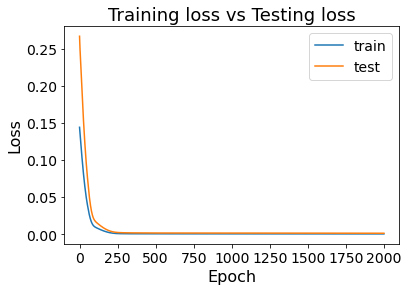

In [38]:
lr = 0.00001
EPOCHS = 2000
model_mlp_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('..saved_model/mlp.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_mlp_60.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                               callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [39]:
from tensorflow.keras.models import load_model

model_load = load_model('../saved_model/mlp.h5')

#### Test set

In [40]:
yhat = model_load.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [43]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [44]:
error = inv_yhat - inv_y
# error

In [45]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [46]:
len(error_19_20)

17544

In [47]:
inv_y.to_csv('../output/inv_y_mlp.csv')
inv_yhat.to_csv('../output/inv_yhat_mlp.csv')
error.to_csv('../output/error_mlp.csv')

### Performance

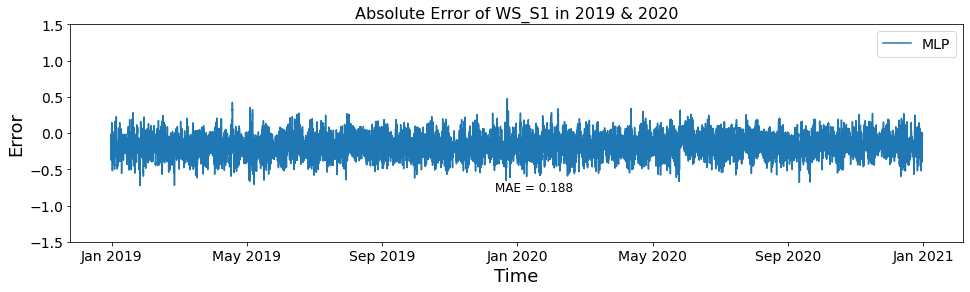

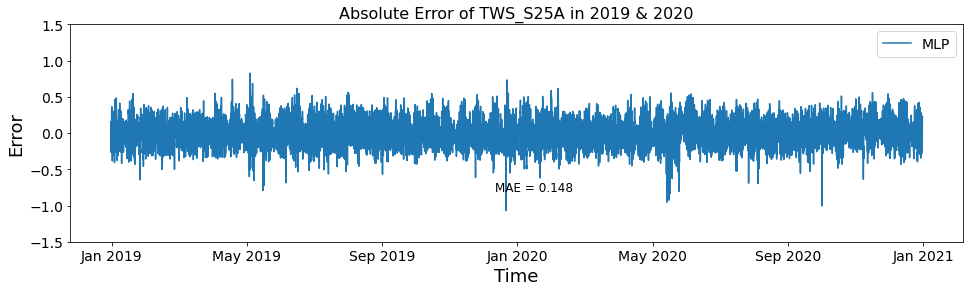

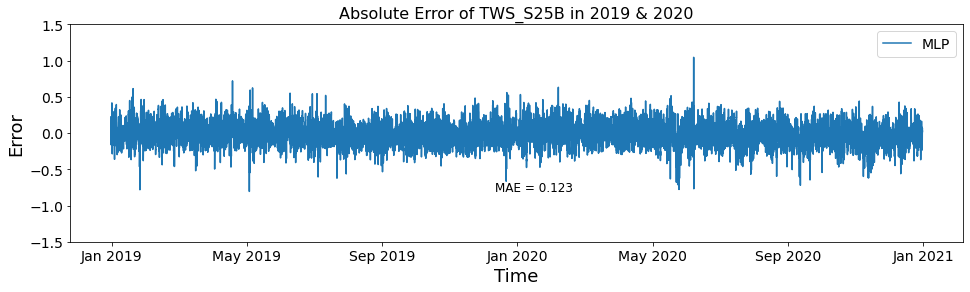

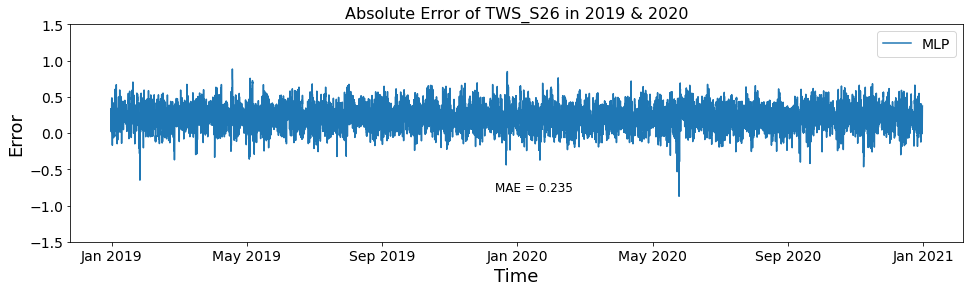

In [48]:
plt.rcParams["figure.figsize"] = (16, 4)
months = ['Jan 2019', 'May 2019', 'Sep 2019', 'Jan 2020', 'May 2020', 'Sep 2020', 'Jan 2021']

# 17544 = 24 hours * (365+366) days
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i, col in enumerate([-4, -3, -2, -1]):
    plt.plot(error.iloc[-17544:, col], label='MLP')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Error', fontsize=18)
    plt.ylim(-1.5, 1.5)
    plt.xticks(np.arange(1726, 19270, 2923), months, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Absolute Error of {} in 2019 & 2020'.format(locations[i]), fontsize=16)
    # plt.savefig('figures/Test_Error_rnn_chop.png', dpi=300)
    plt.text(10000, -0.8, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error.iloc[-17544:, col]))/17544))), fontsize=12)
    plt.show()
    plt.close()

In [50]:
error_24th_hour = error.iloc[:, [-4, -3, -2, -1]]  # last 4 columns --> t+12
error_24th_hour

,92,93,94,95
0,-0.352005,-0.126081,-0.185352,0.021940
1,-0.201880,0.047541,-0.031094,0.153649
2,-0.250081,-0.056508,-0.019776,0.126424
3,-0.325148,-0.132484,-0.116274,0.030319
4,-0.407651,-0.235500,-0.234241,-0.043128
...,...,...,...,...
19244,-0.262760,-0.178982,-0.157123,0.082258
19245,-0.072918,0.010264,0.002184,0.299152
19246,-0.018655,0.101771,0.037465,0.352911
19247,-0.032901,0.164201,0.011669,0.365299


In [51]:
# error.rename(columns = {'11':'WS_S1', '23':'TWS_S25A', '35':'TWS_S25B', '47':'TWS_S26'}, inplace = True)

In [52]:
error_24th_hour.columns = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
error_24th_hour

,WS_S1,TWS_S25A,TWS_S25B,TWS_S26
0,-0.352005,-0.126081,-0.185352,0.021940
1,-0.201880,0.047541,-0.031094,0.153649
2,-0.250081,-0.056508,-0.019776,0.126424
3,-0.325148,-0.132484,-0.116274,0.030319
4,-0.407651,-0.235500,-0.234241,-0.043128
...,...,...,...,...
19244,-0.262760,-0.178982,-0.157123,0.082258
19245,-0.072918,0.010264,0.002184,0.299152
19246,-0.018655,0.101771,0.037465,0.352911
19247,-0.032901,0.164201,0.011669,0.365299


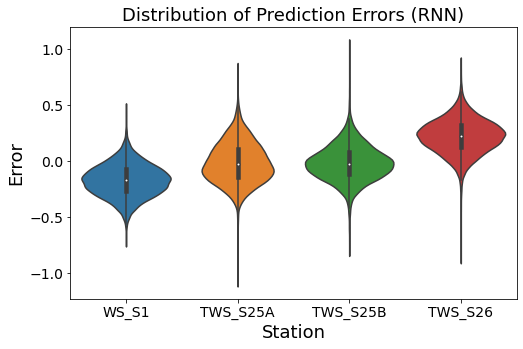

In [53]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 5)
# plt.grid()
plt.xlabel('Station', fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of Prediction Errors (RNN)', fontsize='18')
ax = sns.violinplot(data=error_24th_hour[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']])